## 线性回归模型

略

## 多重共线性
- 完全共线性
- 无共线性
- 近似共线性


本质：属性向量之间线性相关。

多重共线性的存在不仅会导致模型的过拟合，而且还会导致回归模型的稳定性和准确性大大的降低。

解决多重共线性的方法：
- 保留重要特性，去掉次要特征
- 前向逐步回归：将特征逐个引入模型，每引入一个特征之后都要进行F检验，并对已选入的特征逐个进行T检验。  
  当原来引入的特征由于后面特征的引入而变得不在显著时，则将其删除，以确保每次引入新的特征之前回归方程只包含显著性属性。  
  这是一个反复性的过程，直到既没有显著的特征选入回归方程，也没有不显著的特征从回归方程中剔除为止。  
  以保证最后得到的特征集为最优。
- 主成分分析：对于一般的多重共线性还是适用的，尤其对共线性较强的变量之间。当采取主成分提取了新的特征之后，往往这些变量之间的组内差异小而组间差异大，起到了消除贡献性的问题。常见方法PCA降维。
- Lasso回归：Lasso回归就是在线性回归中引入L1正则，它不仅可以解决过拟合的温特，而且可以在参数缩减过程中，将一些重复的参数直接消减为0，带来稀疏特性。
  但是Lasso回归的计算过程复杂，毕竟一范数不是连续可导的。

**实战问题：**  
将2014-04-01\~2014-07-31的数据作为训练集，2014-08-01~2014-08-10的数据集作为测试集。


In [15]:
import pandas as pd
import datetime

def generate_purchase_seq():
  dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y%m%d')
  user_balance = pd.read_csv('user_balance_table.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
  df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
  purchase_seq = pd.Series(df, name='value')
  purchase_seq_train = purchase_seq['2014-04-01':'2014-07-31']
  purchase_seq_test = purchase_seq['2014-08-01':'2014-08-10']

  purchase_seq_train.to_csv('purchase_seq_train.csv', header=True)
  purchase_seq_test.to_csv('purchase_seq_test.csv', header=True)

generate_purchase_seq()

建立线性回归模型的步骤：
- 特征提取
- 模型拟合

特征决定了模型的上界，对于模型的参数调优就是不断地逼近这个上界。

这里我们选取了32个特征：
- 工作日/休息日
- 小长假
- 月初/中/末
- 假期前后
- 新股




In [16]:
import pandas as pd

 # 新股申购日期  新股数量
    # 06.18         4
    # 06.19         1
    # 06.20         1
    # 06.23         2
    # 06.24         1
    # 07.10         1
    # 07.23         5
    # 07.24         4
    # 07.30         1
    # 08.13         1
    # 08.14         1

def generate_common_feature(purchase_seq):
  report_date = purchase_seq.index
  weekday = []
  for i in range(len(report_date)):
    weekday.append(report_date[i].weekday())

  purchase_seq['weekday'] = weekday  #1
  purchase_seq['workday1'] = 0       #2
  purchase_seq['workday2'] = 0       #3
  purchase_seq['workday3'] = 0       #4
  purchase_seq['workday4'] = 0       #5
  purchase_seq['workday5'] = 0       #6
  purchase_seq['weekend1'] = 0       #7
  purchase_seq['weekend2'] = 0       #8

  purchase_seq['holiday1'] = 0       #9
  purchase_seq['holiday2'] = 0       #10
  purchase_seq['holiday3'] = 0       #11

  purchase_seq['before_the_holiday'] = 0         #12
  purchase_seq['after_the_holiday'] = 0          #13

  purchase_seq['workday'] = 0       #14
  purchase_seq['holiday'] = 0       #15

  purchase_seq['begin_month'] = 0     #16
  purchase_seq['mid_month'] = 0       #17
  purchase_seq['end_month'] = 0       #18

  purchase_seq['after_last_workday_num_holidays_byte1'] = 0       #19
  purchase_seq['after_last_workday_num_holidays_byte2'] = 0       #20

  purchase_seq['before_first_workday_num_holidays_byte1'] = 0      #21
  purchase_seq['before_first_workday_num_holidays_byte2'] = 0      #22

  purchase_seq['two_days_holiday'] = 0         #23
  purchase_seq['three_days_holiday'] = 0       #24
  purchase_seq['complement_workday'] = 0       #25

  purchase_seq['before_1_new_share'] = 0       #26
  purchase_seq['before_2_new_share'] = 0       #27
  purchase_seq['before_3_new_share'] = 0       #28
  purchase_seq['new_share'] = 0                #29
  purchase_seq['after_1_new_share'] = 0        #30
  purchase_seq['after_2_new_share'] = 0        #31
  purchase_seq['after_3_new_share'] = 0        #32

  #  常规周处理
  for index, row in purchase_seq.iterrows():
    if (index.day < 11):
      row['begin_month'] = 1
    elif (11 <= index.day < 21):
      row['mid_month'] = 1
    else:
      row['end_month'] = 1

    if row['weekday'] == 0:
      row['workday1'] = 1
      row['after_the_holiday'] = 1
      row['workday'] = 1
      row['before_first_workday_num_holidays_byte1'] = 1
      row['before_first_workday_num_holidays_byte2'] = 0
    elif row['weekday'] == 1:
      row['workday2'] = 1
      row['workday'] = 1
    elif row['weekday'] == 2:
      row['workday3'] = 1
      row['workday'] = 1
    elif row['weekday'] == 3:
      row['workday4'] = 1
      row['workday'] = 1
    elif row['weekday'] == 4:
      row['workday5'] = 1
      row['before_the_holiday'] = 1
      row['workday'] = 1
      row['after_last_workday_num_holidays_byte1'] = 1
      row['after_last_workday_num_holidays_byte2'] = 0
    elif row['weekday'] == 5:
      row['weekend1'] = 1
      row['holiday1'] = 1
      row['holiday'] = 1
      row['two_days_holiday'] = 1
    elif row['weekday'] == 6:
      row['weekend2'] = 1
      row['holiday2'] = 1
      row['holiday'] = 1
      row['two_days_holiday'] = 1

  return purchase_seq

In [17]:
def generate_train_feature(purchase_seq):
  # 新股处理
  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-06-17'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-06-16'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-06-15'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-06-18'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-06-19'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-06-20'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-06-21'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-06-18'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-06-17'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-06-16'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-06-19'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-06-20'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-06-21'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-06-22'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-06-19'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-06-18'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-06-17'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-06-20'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-06-21'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-06-22'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-06-23'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-06-22'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-06-21'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-06-20'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-06-23'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-06-24'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-06-25'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-06-26'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-06-23'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-06-22'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-06-21'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-06-24'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-06-25'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-06-26'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-06-27'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-07-09'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-07-08'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-07-07'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-07-10'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-07-11'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-07-12'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-07-13'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-07-22'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-07-21'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-07-20'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-07-23'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-07-24'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-07-25'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-07-26'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-07-23'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-07-22'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-07-21'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-07-24'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-07-25'] = 1
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-07-26'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-07-27'] = 1

  purchase_seq['before_1_new_share'][purchase_seq.index == '2014-07-29'] = 1
  purchase_seq['before_2_new_share'][purchase_seq.index == '2014-07-28'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-07-27'] = 1
  purchase_seq['new_share'][purchase_seq.index == '2014-07-30'] = 1
  purchase_seq['after_1_new_share'][purchase_seq.index == '2014-07-31'] = 1

  # 节假日处理
  # 清明
  purchase_seq['after_last_workday_num_holidays_byte1'][purchase_seq.index == '2014-04-04'] = 1
  purchase_seq['after_last_workday_num_holidays_byte2'][purchase_seq.index == '2014-04-04'] = 1

  purchase_seq['two_days_holiday'][purchase_seq.index == '2014-04-05'] = 0
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-04-05'] = 1

  purchase_seq['two_days_holiday'][purchase_seq.index == '2014-04-06'] = 0
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-04-06'] = 1

  purchase_seq['workday1'][purchase_seq.index == '2014-04-07'] = 0
  purchase_seq['after_the_holiday'][purchase_seq.index == '2014-04-07'] = 0
  purchase_seq['workday'][purchase_seq.index == '2014-04-07'] = 0
  purchase_seq['before_first_workday_num_holidays_byte1'][purchase_seq.index == '2014-04-07'] = 0
  purchase_seq['before_first_workday_num_holidays_byte2'][purchase_seq.index == '2014-04-07'] = 0
  purchase_seq['holiday3'][purchase_seq.index == '2014-04-07'] = 1
  purchase_seq['holiday'][purchase_seq.index == '2014-04-07'] = 1
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-04-07'] = 1

  purchase_seq['after_the_holiday'][purchase_seq.index == '2014-04-08'] = 1
  purchase_seq['before_first_workday_num_holidays_byte1'][purchase_seq.index == '2014-04-08'] = 1
  purchase_seq['before_first_workday_num_holidays_byte2'][purchase_seq.index == '2014-04-08'] = 1

  # 五一
  purchase_seq['before_the_holiday'][purchase_seq.index == '2014-04-30'] = 1
  purchase_seq['after_last_workday_num_holidays_byte1'][purchase_seq.index == '2014-04-30'] = 1
  purchase_seq['after_last_workday_num_holidays_byte1'][purchase_seq.index == '2014-04-30'] = 1

  purchase_seq['workday4'][purchase_seq.index == '2014-05-01'] = 0
  purchase_seq['workday'][purchase_seq.index == '2014-05-01'] = 0
  purchase_seq['holiday1'][purchase_seq.index == '2014-05-01'] = 1
  purchase_seq['holiday'][purchase_seq.index == '2014-05-01'] = 1
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-05-01'] = 1

  purchase_seq['workday5'][purchase_seq.index == '2014-05-02'] = 0
  purchase_seq['before_the_holiday'][purchase_seq.index == '2014-05-02'] = 0
  purchase_seq['workday'][purchase_seq.index == '2014-05-02'] = 0
  purchase_seq['after_last_workday_num_holidays_byte1'][purchase_seq.index == '2014-05-02'] = 0
  purchase_seq['after_last_workday_num_holidays_byte2'][purchase_seq.index == '2014-05-02'] = 0
  purchase_seq['holiday2'][purchase_seq.index == '2014-05-02'] = 1
  purchase_seq['holiday'][purchase_seq.index == '2014-05-02'] = 1
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-05-02'] = 1

  purchase_seq['holiday1'][purchase_seq.index == '2014-05-03'] = 0
  purchase_seq['holiday3'][purchase_seq.index == '2014-05-03'] = 1
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-05-03'] = 1

  purchase_seq['weekend2'][purchase_seq.index == '2014-05-04'] = 0
  purchase_seq['holiday2'][purchase_seq.index == '2014-05-04'] = 0
  purchase_seq['holiday'][purchase_seq.index == '2014-05-04'] = 0
  purchase_seq['two_days_holiday'][purchase_seq.index == '2014-05-04'] = 0
  purchase_seq['after_the_holiday'][purchase_seq.index == '2014-05-04'] = 1
  purchase_seq['workday'][purchase_seq.index == '2014-05-04'] = 1
  purchase_seq['before_first_workday_num_holidays_byte1'][purchase_seq.index == '2014-05-04'] = 1
  purchase_seq['before_first_workday_num_holidays_byte2'][purchase_seq.index == '2014-05-04'] = 1
  purchase_seq['complement_workday'][purchase_seq.index == '2014-05-04'] = 1

  # 端午
  purchase_seq['after_last_workday_num_holidays_byte1'][purchase_seq.index == '2014-05-30'] = 1
  purchase_seq['after_last_workday_num_holidays_byte2'][purchase_seq.index == '2014-05-30'] = 1

  purchase_seq['two_days_holiday'][purchase_seq.index == '2014-05-31'] = 0
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-05-31'] = 1

  purchase_seq['two_days_holiday'][purchase_seq.index == '2014-06-01'] = 0
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-06-01'] = 1

  purchase_seq['workday1'][purchase_seq.index == '2014-06-02'] = 0
  purchase_seq['after_the_holiday'][purchase_seq.index == '2014-06-02'] = 0
  purchase_seq['workday'][purchase_seq.index == '2014-06-02'] = 0
  purchase_seq['before_first_workday_num_holidays_byte1'][purchase_seq.index == '2014-06-02'] = 0
  purchase_seq['before_first_workday_num_holidays_byte2'][purchase_seq.index == '2014-06-02'] = 0
  purchase_seq['holiday3'][purchase_seq.index == '2014-06-02'] = 1
  purchase_seq['holiday'][purchase_seq.index == '2014-06-02'] = 1
  purchase_seq['three_days_holiday'][purchase_seq.index == '2014-06-02'] = 1

  purchase_seq['after_the_holiday'][purchase_seq.index == '2014-06-03'] = 1
  purchase_seq['before_first_workday_num_holidays_byte1'][purchase_seq.index == '2014-06-03'] = 1
  purchase_seq['before_first_workday_num_holidays_byte2'][purchase_seq.index == '2014-06-03'] = 1

  return purchase_seq


def generate_test_feature(purchase_seq):
  # 新股处理
  purchase_seq['after_2_new_share'][purchase_seq.index == '2014-08-01'] = 1
  purchase_seq['after_3_new_share'][purchase_seq.index == '2014-08-02'] = 1
  purchase_seq['before_3_new_share'][purchase_seq.index == '2014-08-10'] = 1

  # 节假日处理
  return purchase_seq


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_test = pd.read_csv('./purchase_seq_test.csv', parse_dates=['report_date'],
                                index_col='report_date', date_parser=dateparse)

purchase_seq_train = generate_train_feature(generate_common_feature(purchase_seq_train))
purchase_seq_test = generate_test_feature(generate_common_feature(purchase_seq_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:167: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


我们在模型评价中引入残差散点图和R2评分指标。  
- 残差散点图
- R2评价指标：就是将拟合模型与数据的均值模型相比较，当模型效果与均值模型相一致时，R2=0， 通常情况下拟合模型的效果肯定比取均值要好。所以$SS_{res}$比$SS_{tot}$要小，结果在0~1之间，
  - R2越接近0，模型效果越差；
  - R2越接近1，模型效果越好；
  - 如果为负，说明拟合结果还不如均值模型，很有可能是因为数据不存在任何线性关系。
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$,
$$SS_{res} = \sum(y_i-f_i)^2, SS_{tot} = \sum(y_i - \hat{y})$$
$\hat{y}$为样本均值

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


w: [ 25280144.36328831  17278802.64206758  20507179.04931315
  17477087.72516137 -21736996.36025874 -12085602.5197961
  48450697.83127452   5610788.31278698 -62098059.68721322
  -9856505.18721311 -23467820.01162834  -4351774.12522648
  66343776.56163936 -66343776.56163937  22007092.10673277
   3351494.40949079 -25358586.51622371 -23467820.01162839
  -2308196.4019062   -4351774.12522646 -29631918.48851475
  19602278.01979611 -13763598.78640807   7537559.14206772
 -44538427.95446995  18453831.48011119   -516914.77798328
 -10981250.60991144 -22808481.78855971  -4454090.76008146
   2078794.65887325]
b: 245534600.92852774


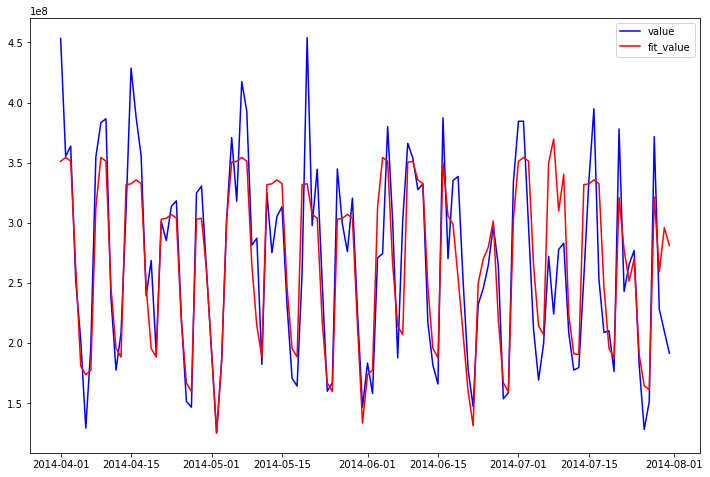

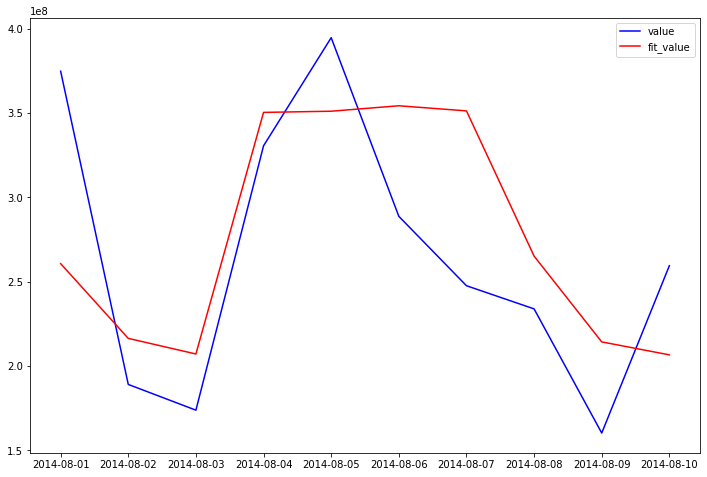

train_score:  0.7331531973501937
test_score:  0.3525500472179268


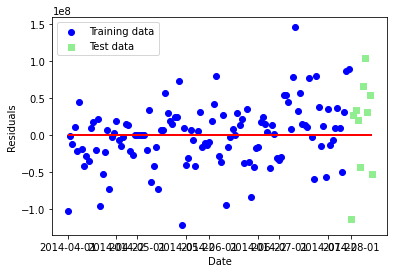

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_test = pd.read_csv('./purchase_seq_test.csv', parse_dates=['report_date'],
                                index_col='report_date', date_parser=dateparse)

purchase_seq_train = generate_train_feature(generate_common_feature(purchase_seq_train))
purchase_seq_test = generate_test_feature(generate_common_feature(purchase_seq_test))

feature = ['workday1', 'workday2', 'workday3', 'workday4', 'workday5', 'weekend1', 'weekend2', 'holiday1', 'holiday2',
           'holiday3', 'before_the_holiday', 'after_the_holiday', 'workday', 'holiday', 'begin_month', 'mid_month',
           'end_month', 'after_last_workday_num_holidays_byte1', 'after_last_workday_num_holidays_byte2',
           'before_first_workday_num_holidays_byte1', 'before_first_workday_num_holidays_byte2', 'two_days_holiday',
           'three_days_holiday', 'complement_workday', 'before_1_new_share', 'before_2_new_share', 'before_3_new_share',
           'new_share', 'after_1_new_share', 'after_2_new_share', 'after_3_new_share']

lr_model = LinearRegression()
lr_model.fit(purchase_seq_train[feature], purchase_seq_train['value'])
w = lr_model.coef_
b = lr_model.intercept_

print('w:', w)
print('b:', b)

purchase_seq_train['fit_value'] = lr_model.predict(purchase_seq_train[feature])

plt.figure(figsize=(12, 8))
plt.plot(purchase_seq_train['value'], label='value', color='blue')
plt.plot(purchase_seq_train['fit_value'], label='fit_value', color='red')
plt.legend(loc='best')
plt.show()

purchase_seq_test['fit_value'] = lr_model.predict(purchase_seq_test[feature])

plt.figure(figsize=(12, 8))
plt.plot(purchase_seq_test['value'], label='value', color='blue')
plt.plot(purchase_seq_test['fit_value'], label='fit_value', color='red')
plt.legend(loc='best')
plt.show()

# 残差评估方法
train_score = lr_model.score(purchase_seq_train[feature], purchase_seq_train['value'])
test_score = lr_model.score(purchase_seq_test[feature], purchase_seq_test['value'])
print("train_score: ", train_score)
print("test_score: ", test_score)

plt.scatter(purchase_seq_train.index, purchase_seq_train['fit_value'] - purchase_seq_train['value'],
            c='blue', marker='o', label='Training data')
plt.scatter(purchase_seq_test.index, purchase_seq_test['fit_value'] - purchase_seq_test['value'],
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=datetime.datetime.strptime('2014-04-01','%Y-%m-%d'), xmax=datetime.datetime.strptime('2014-08-10','%Y-%m-%d'), lw=2, colors='red')
plt.show()

##Lasso Regression
逐步回归法确实可以消除多重共线性，筛选出跟数据标签相关性更强的特征。但是在很多实际业务中，特征维度通常达到千万甚至上亿级别，带来“维数灾难”问题：
- 需要更多的样本，样本随着数据维度的增加呈指数型增长。
- 数据变得更稀疏，导致数据灾难。
- 在高维数据空间，预测将变得不再容易。
- 导致模型过拟合。
- 大量的特征难免引入多重共线性问题。
显然，在高维空间中采用逐步回归法筛选特征是不可行的（计算量太大）。这里介绍 Lasso 回归，通过降维的方法筛选特征。该方法不仅适用于线性模型，也适用于非线性模型。  
**Lasso 是基于惩罚（L1正则）对样本数据进行特征选择，通过对原本的系数进行压缩，将原本很小的系数直接压缩至 0，从而将这部分系数所对应的特征视为非显著性变量，将不显著的变量直接去掉**

如果引入L2正则，即为岭回归。详细略

这里我们通过LassoCV函数进行10折交叉验证来确定超参数$\lambda$，再生成Lasso模型。


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


best alpha:  1216326.7833795585
w:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.18522930e+07  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -4.77494980e+05 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.33477647e+08 -0.00000000e+00  9.95055577e+06  0.00000000e+00
 -2.58682931e+07 -4.02168365e+07 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -1.28881002e+07 -0.00000000e+00
 -1.86251686e+07  0.00000000e+00  0.00000000e+00 -3.55143402e+06
 -1.22922712e+07 -0.00000000e+00 -0.00000000e+00]
b:  192537717.30477363


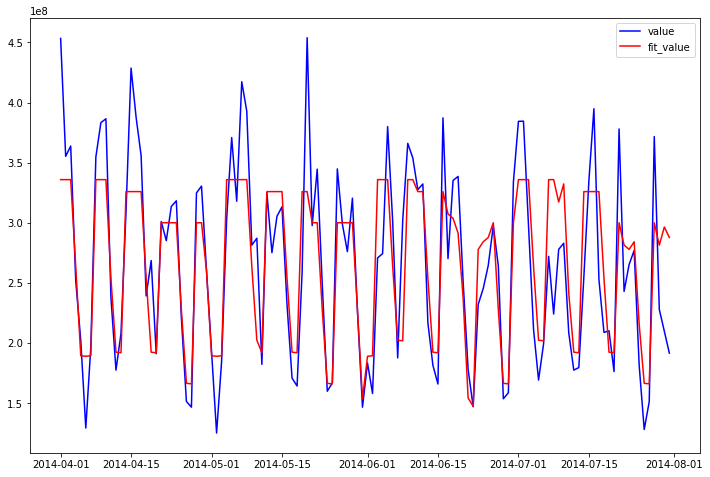

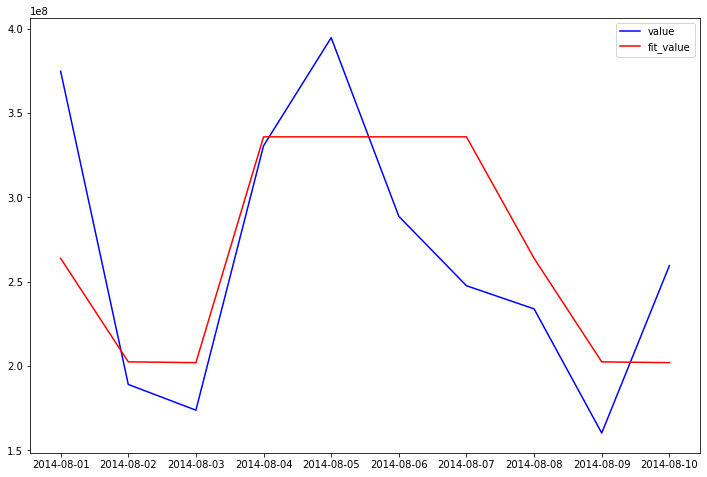

train_score:  0.7032902242462391
test_score:  0.4546590550414088


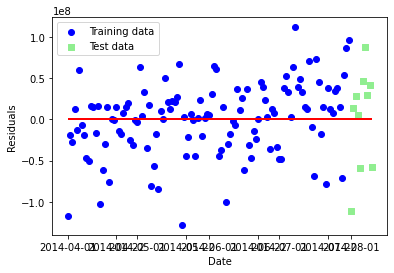

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_test = pd.read_csv('./purchase_seq_test.csv', parse_dates=['report_date'],
                                index_col='report_date', date_parser=dateparse)

purchase_seq_train = generate_train_feature(generate_common_feature(purchase_seq_train))
purchase_seq_test = generate_test_feature(generate_common_feature(purchase_seq_test))

feature = ['workday1', 'workday2', 'workday3', 'workday4', 'workday5', 'weekend1', 'weekend2', 'holiday1', 'holiday2',
           'holiday3', 'before_the_holiday', 'after_the_holiday', 'workday', 'holiday', 'begin_month', 'mid_month',
           'end_month', 'after_last_workday_num_holidays_byte1', 'after_last_workday_num_holidays_byte2',
           'before_first_workday_num_holidays_byte1', 'before_first_workday_num_holidays_byte2', 'two_days_holiday',
           'three_days_holiday', 'complement_workday', 'before_1_new_share', 'before_2_new_share', 'before_3_new_share',
           'new_share', 'after_1_new_share', 'after_2_new_share', 'after_3_new_share']

lassocv_model = LassoCV(cv=10).fit(purchase_seq_train[feature], purchase_seq_train['value'])
alpha = lassocv_model.alpha_
print('best alpha: ', alpha)

lr_model = Lasso(max_iter=1000, alpha=alpha)  # 调节alpha可以实现对拟合的程度
lr_model.fit(purchase_seq_train[feature], purchase_seq_train['value'])  # 线性回归建模

w = lr_model.coef_  # 回归系数
b = lr_model.intercept_  # 截距

print("w: ", w)
print("b: ", b)
# 使用模型预测
purchase_seq_train['fit_value'] = lr_model.predict(purchase_seq_train[feature])
purchase_seq_test['fit_value'] = lr_model.predict(purchase_seq_test[feature])

plt.figure(figsize=(12, 8))
plt.plot(purchase_seq_train['value'], label='value', color='blue')
plt.plot(purchase_seq_train['fit_value'], label='fit_value', color='red')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(purchase_seq_test['value'], label='value', color='blue')
plt.plot(purchase_seq_test['fit_value'], label='fit_value', color='red')
plt.legend(loc='best')
plt.show()

# 残差评估方法
train_score = lr_model.score(purchase_seq_train[feature], purchase_seq_train['value'])
test_score = lr_model.score(purchase_seq_test[feature], purchase_seq_test['value'])
print("train_score: ", train_score)
print("test_score: ", test_score)

plt.scatter(purchase_seq_train.index, purchase_seq_train['fit_value'] - purchase_seq_train['value'],
            c='blue', marker='o', label='Training data')
plt.scatter(purchase_seq_test.index, purchase_seq_test['fit_value'] - purchase_seq_test['value'],
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=datetime.datetime.strptime('2014-04-01','%Y-%m-%d'), xmax=datetime.datetime.strptime('2014-08-10','%Y-%m-%d'), lw=2, colors='red')
plt.show()

##结语

有结果可见，优于单纯LR，但仍不理想。